This Notebook is currently to be used only in gpu environment. The testing has been done in pretrained Alexnet. The class to be analyzed is currently the one with highest probabilty and can be changed

In [73]:
import torch
import torch.nn.functional as F
import torchvision
import cv2
from torchvision import models, transforms

In [74]:
class Net:
  def __init__(self, model, model_name, layer, input_size):
    self.size = input_size
    self.model = model
    self.layer = layer
    self.model_name = model_name
    self.activations = None
    self.gradients = None

  def get_feature_layer(self):
    return self.model.features[11]

  def forward_hook(self, module, input, output):
    # print(output)
    self.activations = output

  def backward_hook(self, module, grad_input, grad_output):
    # print(grad_output[0])
    self.gradients = grad_output
    
  def hook_layer(self, layer):
    layer.register_forward_hook(self.forward_hook)
    layer.register_backward_hook(self.backward_hook)





In [75]:
class GradCam:
  def __init__(self, model, model_name = 'Alexnet', layer = 'Feature11', input_size = (24,24)): #Default initialized to alexnet with last feature layer
    self.net = Net(model, model_name = 'Alexnet', layer = 'Feature11', input_size = (24,24))
  
  def initialize_network(self): 
    self.net.hook_layer(self.net.get_feature_layer())

  def visualize(self, mask, img):
    mask = mask.cpu()
    heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze()), cv2.COLORMAP_JET)
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b])
    
    result = heatmap+img.cpu()
    result = result.div(result.max()).squeeze()
    
    return heatmap.permute(1, 2, 0).numpy(), result.permute(1, 2, 0).numpy()
  
  def predict(self, img):
    device = 'cuda'
    #  if next(self.net.model.parameters()).is_cuda else 'cpu'
    # print(device)
    self.net.model = self.net.model.to(device)
    return self.net.model(img)
  
  def preprocess(self, img):
    # print(img.shape)
    img = torch.from_numpy(img).permute(2,0,1).float().div(255)
    # img = F.upsample(img, size=(224, 224), mode='bilinear', align_corners=False)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    return (F.upsample(normalize(img).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)).cuda()
  
  def forward(self, tensor_img):
    d, c, h, w = tensor_img.shape
    pred = self.predict(tensor_img)

    S_c = pred[:, pred.max(1).indices]
    Y_c = torch.exp(S_c)

    self.net.model.zero_grad()

    S_c.backward()

    gradients = self.net.gradients[0]

    activations = self.net.activations

    d, k, u, v = gradients.shape

    alpha_n = gradients.pow(2)

    alpha_d = gradients.pow(2).mul(2) + activations.mul(gradients.pow(3)).view(d, k ,u*v).sum(-1, keepdim = True).view(d, k, 1, 1)

    alpha = alpha_n.div(alpha_d+1e-7)

    gradient_Y_c = F.relu(Y_c*gradients)

    weight = alpha.mul(gradient_Y_c).view(d, k, u*v).sum(-1).view(d, k, 1, 1)

    L = (weight.mul(activations)).sum(1, keepdim = True)

    L = F.relu(L)

    L = F.upsample(L, size=(h,w), mode='bilinear', align_corners=False)

    L_min, L_max = L.min(), L.max()

    L = (L-L_min).div(L_max-L_min).data

    # print(L.shape)

    return L
    
    # return (alpha_n, alpha_d)

    


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


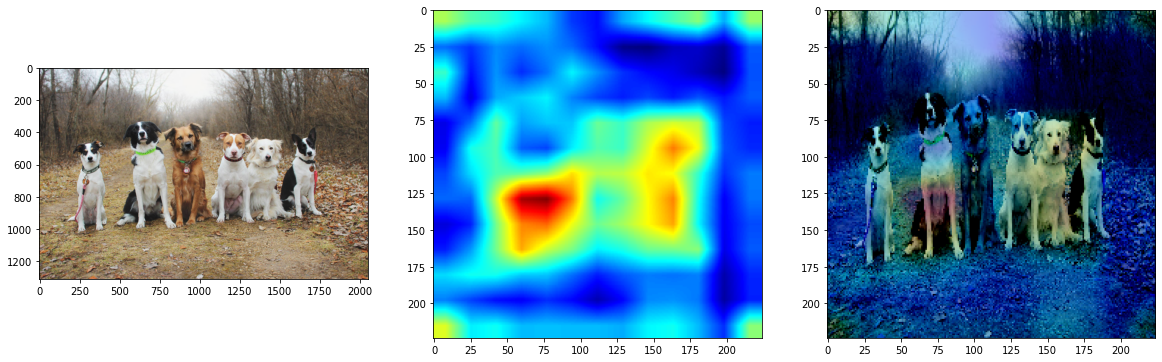

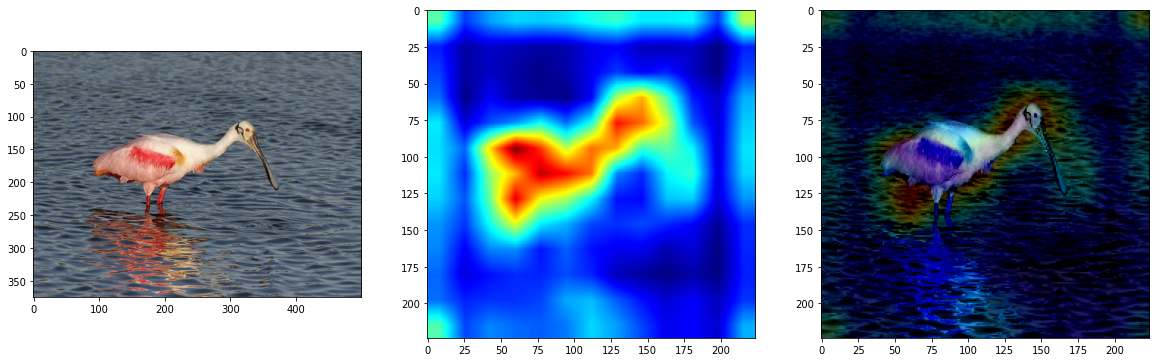

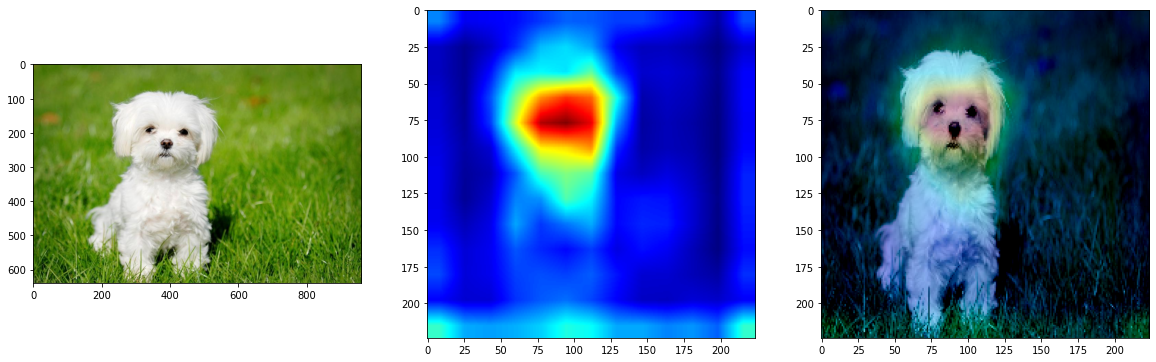

In [77]:
import numpy as np
import matplotlib.pyplot as plt
g = GradCam(models.alexnet(pretrained = True)) #Pass the model

for i in range(1,4):
  img = cv2.imread('input/'+str(i)+'.jpg') #read image
  g.initialize_network() #To set layer for with values have to be evaluated
  mask = g.forward(g.preprocess(img)) # Returns the saliency_map
  heat_map, result = g.visualize(mask, g.preprocess(img)) #Visualize the results
  fig = plt.figure(figsize = (20,20))
  fig.add_subplot(1,3,1)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  fig.add_subplot(1,3,2)
  plt.imshow(heat_map)
  fig.add_subplot(1,3,3)
  plt.imshow(result)
  plt.savefig('output/'+str(i)+'.png')